In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from glob import glob

from utils.plotter import Plotter
from utils.data_handler import DataHandler

labels = ["bias"]
root = lambda x, y: f"./outputs_{x}/work{y}/"
n_works = len(glob(root(labels[0], "*")))
template = lambda x, y: f"{root(x, y)}/DFM_OUTPUT_dcsmv5/"
data_folder = lambda x: template(labels[0], x)
noise_file = lambda x: f"{root(labels[0], x)}/dcsmv5_airpressure_noise.nc"
folder = data_folder(0)
output_folder = "figs"

obs_file = "./stochObserver/clipped_averaged_20cm.nc"

map_file = "dcsmv5_map.nc"
his_file = "full_dcsmv5_his.nc"
av_file = "full_dcsmv5_averaged_his.nc"
no_filter_file = "./stochObserver/dcsmv5_his.nc"

In [ ]:
for i in range(n_works):
    nc = xr.load_dataset(noise_file(i))
    nc.interp(y=52.9, x=4.7).p.plot(label=f"{i}")

In [ ]:
map_nc = xr.load_dataset(os.path.join(folder, map_file))
map_nc

In [ ]:
t = 9

vars = ["s1"]
# vars = ["s1", "s0", "ucx", "ucy"]
for var in vars:
    map_file = os.path.join(folder, map_file)
    nc = xr.load_dataset(map_file)
    x = nc.FlowElem_xcc
    y = nc.FlowElem_ycc

    z = getattr(nc, var)[t, :]

    Plotter.plot_map(
        x,
        y,
        z,
        size=5,
        # path=f"{var}_t{t}.png",
    )
    plt.show()

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Waterlevel at 87'}, xlabel='Time', ylabel='$h\\ (\\mathrm{m})$'>)

<Figure size 640x480 with 0 Axes>

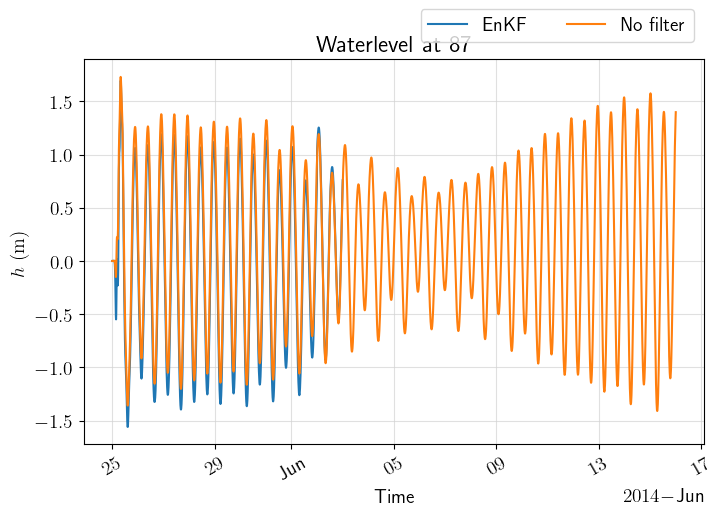

In [3]:
obs_data = xr.load_dataset(obs_file)

station = 3

title_func = lambda s: f"Waterlevel at {s}"
ts = []
ws = []
works = ["0"]
runs = ["EnKF", "No filter"]
for work in works:
    file = os.path.join(data_folder(work), "full_dcsmv5_his.nc")
    nc_his = xr.load_dataset(file)
    station_data = nc_his.isel(stations=station)
    ts.append(station_data.time)
    ws.append(station_data.waterlevel)
    loc_name = nc_his.station_name[station].item()[0]

station_data = xr.load_dataset(no_filter_file).isel(stations=station)
ts.append(station_data.time)
ws.append(station_data.waterlevel)
Plotter.plot_series(
    ts,
    ws,
    loc_name,
    title_func,
    legends=runs,
    # obs_data=obs_data,
)

<Figure size 640x480 with 0 Axes>

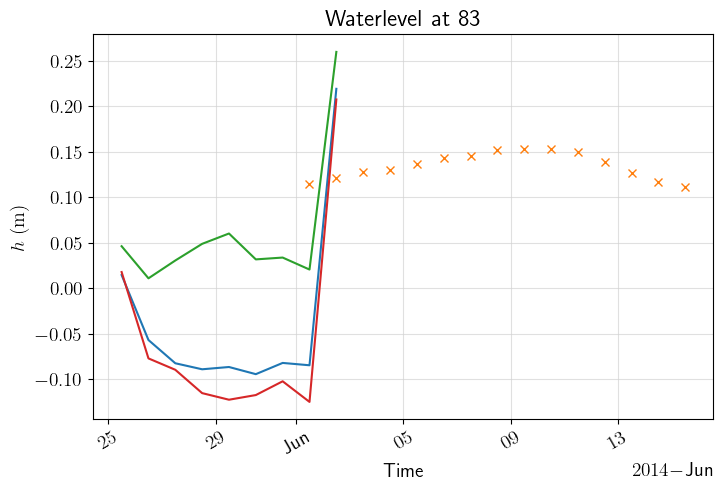

<Figure size 640x480 with 0 Axes>

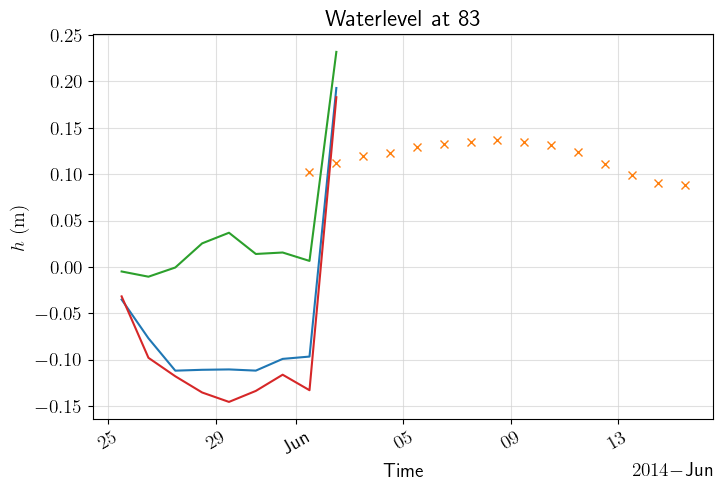

<Figure size 640x480 with 0 Axes>

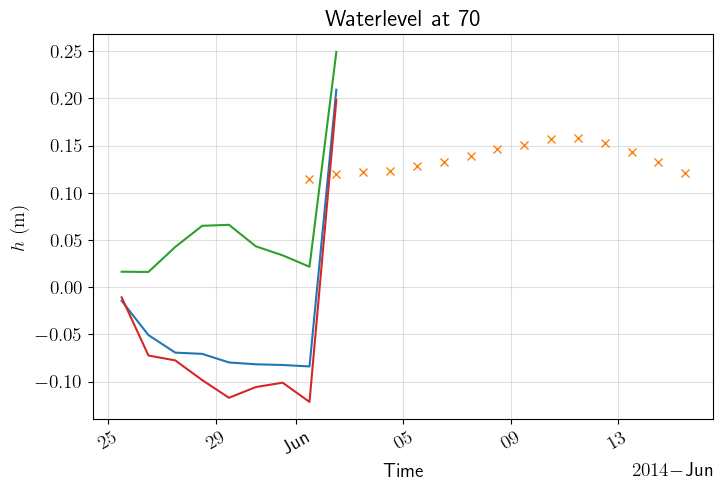

<Figure size 640x480 with 0 Axes>

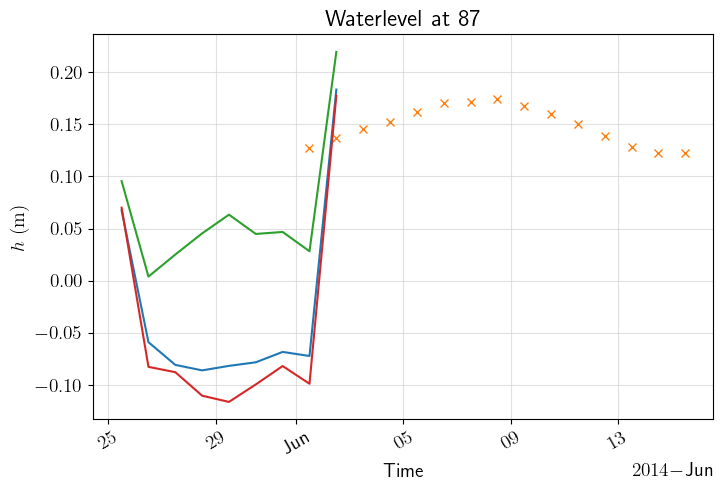

<Figure size 640x480 with 0 Axes>

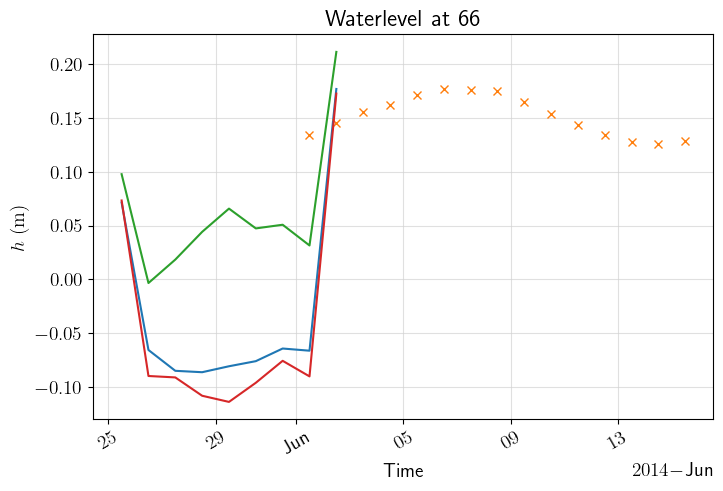

In [4]:
stations = range(5)
for station in stations:
    title_func = lambda s: f"Waterlevel at {s}"
    ts = []
    ws = []
    works = list(range(n_works))
    works = [str(x) for x in works]
    for work in works:
        file = os.path.join(data_folder(work), "full_dcsmv5_averaged_his.nc")
        nc_his = xr.load_dataset(file)
        station_data = nc_his.isel(stations=station)
        ts.append(station_data.time)
        loc_name = nc_his.station_name[station].item()[0]
        ws.append(station_data.waterlevel)

    # Observations
    station_data = obs_data.isel(stations=station)
    observations = [station_data.time.to_numpy(), station_data.waterlevel.to_numpy()]
    Plotter.plot_series(
        ts,
        ws,
        loc_name,
        title_func,
        obs_data=observations,
    )
    plt.show()

In [ ]:
from datetime import datetime, timedelta, timezone

nc = xr.load_dataset("./algorithm/kgStorage_201405270000/kalmanGainStorage.nc")

In [ ]:
from datetime import datetime, timedelta, timezone

files = glob("./algorithm/*/*.nc")
data_files = [xr.open_dataset(file) for file in files]
ncs = []
times = []
for file in files:
    nc = xr.load_dataset(file)
    time = pd.to_datetime(datetime(1858, 11, 17)) + nc.time_stamp.values[0]
    nc["time_stamp"] = time
    ncs.append(nc)
    times.append(time)

nc = xr.concat(ncs, pd.Index(times, name="time"))
nc = nc.rename_dims({"station_dimension": "stations"})
nc.isel(stations=0).s1[:, 0].plot()